# Paper 1: Regularization Effectiveness Study
## Autoren: Katrin Nguyen & Nico Loss

## Import & Setup

In [79]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import warnings
from ydata_profiling import ProfileReport

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.exceptions import ConvergenceWarning

from scipy.stats import ttest_rel

# Suppress convergence warnings for cleaner output
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Matplotlib inline for Jupyter Notebooks
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Global variables
CV = 5
LOGSPACE = np.logspace(-4, 2, 30)
MAX_ITER = 10000

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Create directories for Reports/diagrams if they do not exist
Path("Reports").mkdir(exist_ok=True)
Path("Save").mkdir(exist_ok=True)

## Preprocessing Function

In [80]:
def preprocess_data(df, fit_encodings=False):
    """
    Bereinigt und transformiert Diamond-Daten.

    Parameters:
    -----------
    df : pd.DataFrame
        Der zu bereinigende DataFrame
    fit_encodings : bool
        Wenn True, werden neue Encoding-Mappings erstellt (für Trainingsdaten)
        Wenn False, werden existierende Mappings verwendet (für Val/Test)

    Returns:
    --------
    df_clean : pd.DataFrame
        Bereinigter DataFrame
    encodings : dict (nur wenn fit_encodings=True)
        Dictionary mit Encoding-Mappings
    """
    df_clean = df.copy()

    # 1. Remove diamonds with zero dimensions
    initial_size = len(df_clean)
    df_clean = df_clean[(df_clean['x'] > 0) & (df_clean['y'] > 0) & (df_clean['z'] > 0)]
    print(f"  Removed {initial_size - len(df_clean)} rows with zero dimensions")

    # 2. Remove extreme outliers using IQR method
    for col in ['x', 'y', 'z']:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        size_before = len(df_clean)
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        print(f"  Removed {size_before - len(df_clean)} outliers from {col}")

    # 3. Ordinal encoding for categorical variables
    if fit_encodings:
        # Erstelle neue Mappings basierend auf Trainingsdaten
        cut_mapping = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
        color_mapping = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
        clarity_mapping = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}

        encodings = {
            'cut': cut_mapping,
            'color': color_mapping,
            'clarity': clarity_mapping
        }
    else:
        # Verwende globale Encodings (müssen vorher definiert sein)
        encodings = GLOBAL_ENCODINGS

    df_clean['cut_encoded'] = df_clean['cut'].map(encodings['cut'])
    df_clean['color_encoded'] = df_clean['color'].map(encodings['color'])
    df_clean['clarity_encoded'] = df_clean['clarity'].map(encodings['clarity'])

    # Handle missing values after encoding (falls neue Kategorien in Test/Val)
    if df_clean['cut_encoded'].isna().any():
        print(f"  Warning: {df_clean['cut_encoded'].isna().sum()} unknown cut values - using median")
        df_clean['cut_encoded'].fillna(df_clean['cut_encoded'].median(), inplace=True)
    if df_clean['color_encoded'].isna().any():
        print(f"  Warning: {df_clean['color_encoded'].isna().sum()} unknown color values - using median")
        df_clean['color_encoded'].fillna(df_clean['color_encoded'].median(), inplace=True)
    if df_clean['clarity_encoded'].isna().any():
        print(f"  Warning: {df_clean['clarity_encoded'].isna().sum()} unknown clarity values - using median")
        df_clean['clarity_encoded'].fillna(df_clean['clarity_encoded'].median(), inplace=True)

    # 4. Feature Engineering
    df_clean['volume'] = df_clean['x'] * df_clean['y'] * df_clean['z']
    df_clean['carat_squared'] = df_clean['carat'] ** 2
    df_clean['xy_ratio'] = df_clean['x'] / df_clean['y']
    df_clean['depth_table_ratio'] = df_clean['depth'] / df_clean['table']

    print(f"  Final shape: {len(df_clean)} rows")

    if fit_encodings:
        return df_clean, encodings
    else:
        return df_clean


## Data Loading
Download Dataset from Kaggle.com: https://www.kaggle.com/datasets/shivam2503/diamonds

In [81]:
path = kagglehub.dataset_download("shivam2503/diamonds")

print("Path to dataset files:", path)

df = pd.read_csv(path + "\\diamonds.csv")

df.drop(columns=["Unnamed: 0"], inplace=True) # Fehlerhafte Index Column entfernen

print("Dataset successfully loaded!")

Path to dataset files: C:\Users\nicol\.cache\kagglehub\datasets\shivam2503\diamonds\versions\1
Dataset successfully loaded!


## Train-Validation-Test Split

In [82]:
print("\n" + "="*50)
print("TRAIN-VALIDATION-TEST SPLIT (BEFORE PREPROCESSING)")
print("="*50)

# First split: separate test set (20%)
df_temp, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Second split: separate train (60%) and validation (20% of total = 25% of temp)
df_train, df_val = train_test_split(df_temp, test_size=0.25, random_state=42)

print(f"Training set (raw): {len(df_train)} samples")
print(f"Validation set (raw): {len(df_val)} samples")
print(f"Test set (raw): {len(df_test)} samples")


TRAIN-VALIDATION-TEST SPLIT (BEFORE PREPROCESSING)
Training set (raw): 32364 samples
Validation set (raw): 10788 samples
Test set (raw): 10788 samples


## Data Prepocessing

In [83]:
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Process training data and create encodings
print("Processing Training Data:")
df_train_clean, GLOBAL_ENCODINGS = preprocess_data(df_train, fit_encodings=True)

# Process validation data using training encodings
print("\nProcessing Validation Data:")
df_val_clean = preprocess_data(df_val, fit_encodings=False)

# Process test data using training encodings
print("\nProcessing Test Data:")
df_test_clean = preprocess_data(df_test, fit_encodings=False)

print("\n" + "="*50)
print("CLEANED DATA SUMMARY")
print("="*50)
print(f"Training set (cleaned): {len(df_train_clean)} samples")
print(f"Validation set (cleaned): {len(df_val_clean)} samples")
print(f"Test set (cleaned): {len(df_test_clean)} samples")


DATA PREPROCESSING
Processing Training Data:
  Removed 16 rows with zero dimensions
  Removed 0 outliers from x
  Removed 2 outliers from y
  Removed 1 outliers from z
  Final shape: 32345 rows

Processing Validation Data:
  Removed 3 rows with zero dimensions
  Removed 0 outliers from x
  Removed 0 outliers from y
  Removed 0 outliers from z
  Final shape: 10785 rows

Processing Test Data:
  Removed 1 rows with zero dimensions
  Removed 0 outliers from x
  Removed 0 outliers from y
  Removed 0 outliers from z
  Final shape: 10787 rows

CLEANED DATA SUMMARY
Training set (cleaned): 32345 samples
Validation set (cleaned): 10785 samples
Test set (cleaned): 10787 samples


## Prepare Features and Target

In [84]:
print("\n" + "="*50)
print("FEATURE AND TARGET PREPARATION")
print("="*50)

feature_cols = ['carat', 'cut_encoded', 'color_encoded', 'clarity_encoded',
                'depth', 'table', 'x', 'y', 'z', 'volume', 'carat_squared',
                'xy_ratio', 'depth_table_ratio']

# Extract features and targets from cleaned dataframes
X_train = df_train_clean[feature_cols].values
y_train = df_train_clean['price'].values

X_val = df_val_clean[feature_cols].values
y_val = df_val_clean['price'].values

X_test = df_test_clean[feature_cols].values
y_test = df_test_clean['price'].values

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


FEATURE AND TARGET PREPARATION
X_train shape: (32345, 13)
X_val shape: (10785, 13)
X_test shape: (10787, 13)


## Feature Scaling

In [85]:
print("\n" + "="*50)
print("FEATURE SCALING")
print("="*50)

# WICHTIG: Scaler nur auf Trainingsdaten fitten!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler (fitted on training set only)")
print("All data is now ready for model training!")

# Überprüfung der Datenverteilung nach Split und Cleaning
print("\n" + "="*50)
print("DATA DISTRIBUTION CHECK")
print("="*50)

# Vergleich der Preisverteilungen
print("Price statistics:")
print(f"Train - Mean: ${y_train.mean():.2f}, Std: ${y_train.std():.2f}")
print(f"Val   - Mean: ${y_val.mean():.2f}, Std: ${y_val.std():.2f}")
print(f"Test  - Mean: ${y_test.mean():.2f}, Std: ${y_test.std():.2f}")

# Vergleich der Feature-Verteilungen (Beispiel: carat)
print("\nCarat statistics:")
print(f"Train - Mean: {df_train_clean['carat'].mean():.3f}, Std: {df_train_clean['carat'].std():.3f}")
print(f"Val   - Mean: {df_val_clean['carat'].mean():.3f}, Std: {df_val_clean['carat'].std():.3f}")
print(f"Test  - Mean: {df_test_clean['carat'].mean():.3f}, Std: {df_test_clean['carat'].std():.3f}")


FEATURE SCALING
Features scaled using StandardScaler (fitted on training set only)
All data is now ready for model training!

DATA DISTRIBUTION CHECK
Price statistics:
Train - Mean: $3954.31, Std: $4000.04
Val   - Mean: $3885.83, Std: $3947.78
Test  - Mean: $3905.81, Std: $3987.20

Carat statistics:
Train - Mean: 0.800, Std: 0.474
Val   - Mean: 0.793, Std: 0.471
Test  - Mean: 0.797, Std: 0.477


## Data Exploration

In [86]:
print("\nDataset Info:")
print("="*50)
print(df_train_clean.info())

print("\nFirst 5 rows:")
print("="*50)
print(df_train_clean.head())

print("\nStatistical Summary:")
print("="*50)
print(df_train_clean.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 32345 entries, 40285 to 49854
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   carat              32345 non-null  float64
 1   cut                32345 non-null  object 
 2   color              32345 non-null  object 
 3   clarity            32345 non-null  object 
 4   depth              32345 non-null  float64
 5   table              32345 non-null  float64
 6   price              32345 non-null  int64  
 7   x                  32345 non-null  float64
 8   y                  32345 non-null  float64
 9   z                  32345 non-null  float64
 10  cut_encoded        32345 non-null  int64  
 11  color_encoded      32345 non-null  int64  
 12  clarity_encoded    32345 non-null  int64  
 13  volume             32345 non-null  float64
 14  carat_squared      32345 non-null  float64
 15  xy_ratio           32345 non-null  float64
 16  depth_ta

## Automatisches Reporting erstellen

In [87]:
profile = ProfileReport(df_train_clean, title="Analyse Diamond Report", explorative=True)
profile.to_file("Reports\\DiamonAnalyses_ydata_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


## Explorative Data Analysis


EXPLORATORY DATA ANALYSIS


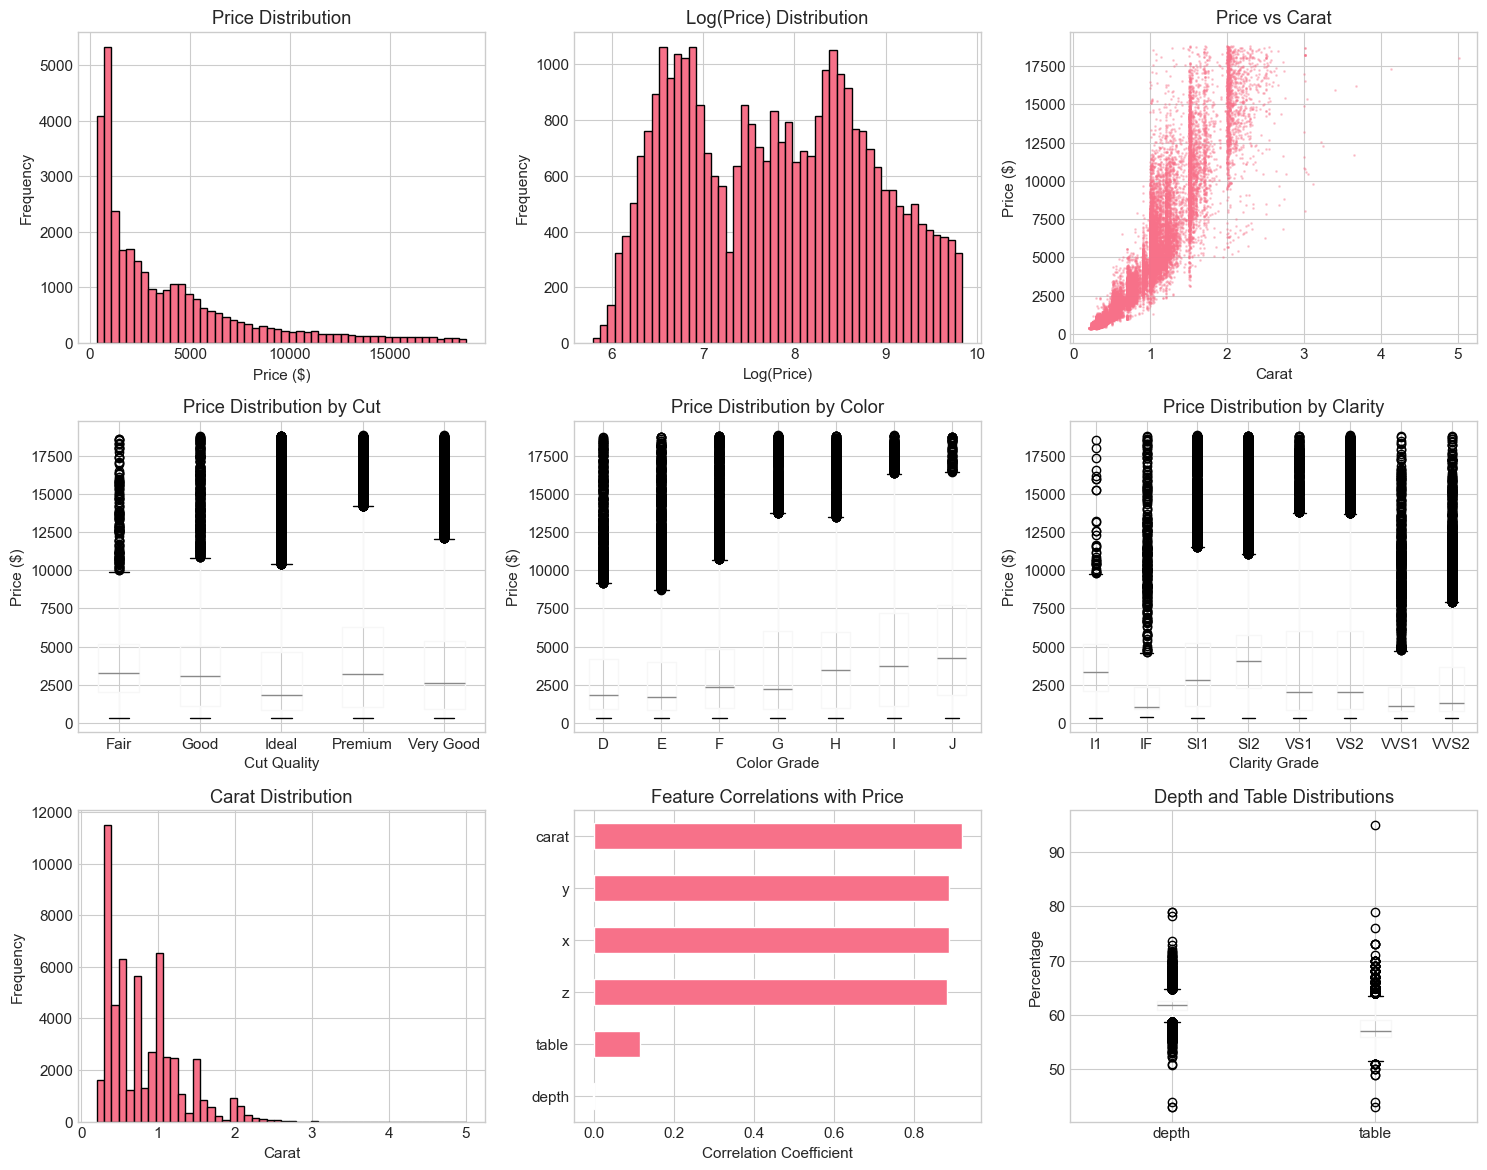

In [88]:
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Create figure for EDA plots
fig = plt.figure(figsize=(15, 12))

# 1. Price distribution
ax1 = plt.subplot(3, 3, 1)
df_train_clean['price'].hist(bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

# 2. Log-transformed price distribution
ax2 = plt.subplot(3, 3, 2)
np.log1p(df_train_clean['price']).hist(bins=50, edgecolor='black')
plt.title('Log(Price) Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

# 3. Price vs Carat
ax3 = plt.subplot(3, 3, 3)
plt.scatter(df_train_clean['carat'], df_train_clean['price'], alpha=0.3, s=1)
plt.title('Price vs Carat')
plt.xlabel('Carat')
plt.ylabel('Price ($)')

# 4. Price by Cut
ax4 = plt.subplot(3, 3, 4)
df.boxplot(column='price', by='cut', ax=ax4)
plt.title('Price Distribution by Cut')
plt.suptitle('')
plt.xlabel('Cut Quality')
plt.ylabel('Price ($)')

# 5. Price by Color
ax5 = plt.subplot(3, 3, 5)
df.boxplot(column='price', by='color', ax=ax5)
plt.title('Price Distribution by Color')
plt.suptitle('')
plt.xlabel('Color Grade')
plt.ylabel('Price ($)')

# 6. Price by Clarity
ax6 = plt.subplot(3, 3, 6)
df.boxplot(column='price', by='clarity', ax=ax6)
plt.title('Price Distribution by Clarity')
plt.suptitle('')
plt.xlabel('Clarity Grade')
plt.ylabel('Price ($)')

# 7. Carat distribution
ax7 = plt.subplot(3, 3, 7)
df['carat'].hist(bins=50, edgecolor='black')
plt.title('Carat Distribution')
plt.xlabel('Carat')
plt.ylabel('Frequency')

# 8. Correlation with price
ax8 = plt.subplot(3, 3, 8)
numeric_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
correlations = df_train_clean[numeric_cols + ['price']].corr()['price'].drop('price').sort_values()
correlations.plot(kind='barh')
plt.title('Feature Correlations with Price')
plt.xlabel('Correlation Coefficient')

# 9. Feature distributions
ax9 = plt.subplot(3, 3, 9)
df[['depth', 'table']].boxplot(ax=ax9)
plt.title('Depth and Table Distributions')
plt.ylabel('Percentage')

plt.tight_layout()
plt.savefig('Save\\eda_diamonds.png', dpi=300, bbox_inches='tight')
plt.show()

## Baseline-Model

In [89]:
print("\n" + "="*50)
print("BASELINE MODEL - ORDINARY LEAST SQUARES")
print("="*50)

# Train baseline model
baseline = LinearRegression()
baseline.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_baseline = baseline.predict(X_train_scaled)
y_val_pred_baseline = baseline.predict(X_val_scaled)
y_test_pred_baseline = baseline.predict(X_test_scaled)

# Evaluate baseline
baseline_metrics = {
    'Train R²': r2_score(y_train, y_train_pred_baseline),
    'Val R²': r2_score(y_val, y_val_pred_baseline),
    'Test R²': r2_score(y_test, y_test_pred_baseline),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_baseline)),
    'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred_baseline)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_baseline)),
    'Train MAE': mean_absolute_error(y_train, y_train_pred_baseline),
    'Val MAE': mean_absolute_error(y_val, y_val_pred_baseline),
    'Test MAE': mean_absolute_error(y_test, y_test_pred_baseline)
}

print("Baseline Performance:")
for metric, value in baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")

train_test_gap = baseline_metrics['Train R²'] - baseline_metrics['Test R²']
print(f"\nTrain-Test R² Gap: {train_test_gap:.4f}")
if train_test_gap > 0.05:
    print("  → Indication of overfitting")


BASELINE MODEL - ORDINARY LEAST SQUARES
Baseline Performance:
  Train R²: 0.9195
  Val R²: 0.9212
  Test R²: 0.9223
  Train RMSE: 1135.1054
  Val RMSE: 1108.1473
  Test RMSE: 1111.1413
  Train MAE: 761.5389
  Val MAE: 757.4239
  Test MAE: 755.6297

Train-Test R² Gap: -0.0029


## Ridge Regression

In [90]:
print("\n" + "="*50)
print("RIDGE REGRESSION (L2 REGULARIZATION)")
print("="*50)

# Hyperparameter tuning with cross-validation
alphas_ridge = LOGSPACE
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=CV, scoring='r2')
ridge_cv.fit(X_train_scaled, y_train)

print(f"Optimal alpha: {ridge_cv.alpha_:.6f}")

# Train final Ridge model
ridge_best = Ridge(alpha=ridge_cv.alpha_)
ridge_best.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_ridge = ridge_best.predict(X_train_scaled)
y_val_pred_ridge = ridge_best.predict(X_val_scaled)
y_test_pred_ridge = ridge_best.predict(X_test_scaled)

# Evaluate Ridge
ridge_metrics = {
    'Train R²': r2_score(y_train, y_train_pred_ridge),
    'Val R²': r2_score(y_val, y_val_pred_ridge),
    'Test R²': r2_score(y_test, y_test_pred_ridge),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_ridge)),
    'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred_ridge)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)),
    'Train MAE': mean_absolute_error(y_train, y_train_pred_ridge),
    'Val MAE': mean_absolute_error(y_val, y_val_pred_ridge),
    'Test MAE': mean_absolute_error(y_test, y_test_pred_ridge)
}

print("\nRidge Performance:")
for metric, value in ridge_metrics.items():
    print(f"  {metric}: {value:.4f}")


RIDGE REGRESSION (L2 REGULARIZATION)
Optimal alpha: 0.126896

Ridge Performance:
  Train R²: 0.9195
  Val R²: 0.9211
  Test R²: 0.9222
  Train RMSE: 1135.1691
  Val RMSE: 1108.6280
  Test RMSE: 1111.9417
  Train MAE: 761.8553
  Val MAE: 757.9002
  Test MAE: 756.0450


## Lasso Regression

In [91]:
print("\n" + "="*50)
print("LASSO REGRESSION (L1 REGULARIZATION)")
print("="*50)

# Hyperparameter tuning with cross-validation
alphas_lasso = LOGSPACE
lasso_cv = LassoCV(alphas=alphas_lasso, cv=CV, max_iter=MAX_ITER, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

print(f"Optimal alpha: {lasso_cv.alpha_:.6f}")

# Train final Lasso model
lasso_best = Lasso(alpha=lasso_cv.alpha_, max_iter=MAX_ITER)
lasso_best.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lasso = lasso_best.predict(X_train_scaled)
y_val_pred_lasso = lasso_best.predict(X_val_scaled)
y_test_pred_lasso = lasso_best.predict(X_test_scaled)

# Evaluate Lasso
lasso_metrics = {
    'Train R²': r2_score(y_train, y_train_pred_lasso),
    'Val R²': r2_score(y_val, y_val_pred_lasso),
    'Test R²': r2_score(y_test, y_test_pred_lasso),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_lasso)),
    'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred_lasso)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)),
    'Train MAE': mean_absolute_error(y_train, y_train_pred_lasso),
    'Val MAE': mean_absolute_error(y_val, y_val_pred_lasso),
    'Test MAE': mean_absolute_error(y_test, y_test_pred_lasso)
}

print("\nLasso Performance:")
for metric, value in lasso_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Feature selection analysis
n_features_selected = np.sum(lasso_best.coef_ != 0)
print(f"\nFeatures selected by Lasso: {n_features_selected}/{len(feature_cols)}")
print("Selected features:")
for i, (feature, coef) in enumerate(zip(feature_cols, lasso_best.coef_)):
    if coef != 0:
        print(f"  {feature}: {coef:.4f}")


LASSO REGRESSION (L1 REGULARIZATION)
Optimal alpha: 0.048939

Lasso Performance:
  Train R²: 0.9192
  Val R²: 0.9207
  Test R²: 0.9216
  Train RMSE: 1136.8040
  Val RMSE: 1112.0379
  Test RMSE: 1116.1955
  Train MAE: 763.9240
  Val MAE: 760.5143
  Test MAE: 758.5403

Features selected by Lasso: 13/13
Selected features:
  carat: 5301.8973
  cut_encoded: 114.0092
  color_encoded: 568.1949
  clarity_encoded: 793.0673
  depth: 357.0897
  table: -317.5654
  x: -12730.6901
  y: 10175.6008
  z: -3511.2922
  volume: 7851.8699
  carat_squared: -3300.4884
  xy_ratio: 569.2169
  depth_table_ratio: -380.8999


## Elastic Net

In [92]:
print("\n" + "="*50)
print("ELASTIC NET (L1 + L2 REGULARIZATION)")
print("="*50)

# Hyperparameter tuning with cross-validation
alphas_elastic = LOGSPACE
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
elastic_cv = ElasticNetCV(
    alphas=alphas_elastic,
    l1_ratio=l1_ratios,
    cv=CV,
    max_iter=MAX_ITER,
    random_state=42
)
elastic_cv.fit(X_train_scaled, y_train)

print(f"Optimal alpha: {elastic_cv.alpha_:.6f}")
print(f"Optimal l1_ratio: {elastic_cv.l1_ratio_:.2f}")

# Train final ElasticNet model
elastic_best = ElasticNet(
    alpha=elastic_cv.alpha_,
    l1_ratio=elastic_cv.l1_ratio_,
    max_iter=MAX_ITER
)
elastic_best.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_elastic = elastic_best.predict(X_train_scaled)
y_val_pred_elastic = elastic_best.predict(X_val_scaled)
y_test_pred_elastic = elastic_best.predict(X_test_scaled)

# Evaluate ElasticNet
elastic_metrics = {
    'Train R²': r2_score(y_train, y_train_pred_elastic),
    'Val R²': r2_score(y_val, y_val_pred_elastic),
    'Test R²': r2_score(y_test, y_test_pred_elastic),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_elastic)),
    'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred_elastic)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_elastic)),
    'Train MAE': mean_absolute_error(y_train, y_train_pred_elastic),
    'Val MAE': mean_absolute_error(y_val, y_val_pred_elastic),
    'Test MAE': mean_absolute_error(y_test, y_test_pred_elastic)
}

print("\nElasticNet Performance:")
for metric, value in elastic_metrics.items():
    print(f"  {metric}: {value:.4f}")


ELASTIC NET (L1 + L2 REGULARIZATION)
Optimal alpha: 0.000100
Optimal l1_ratio: 0.90

ElasticNet Performance:
  Train R²: 0.9192
  Val R²: 0.9206
  Test R²: 0.9216
  Train RMSE: 1137.0203
  Val RMSE: 1112.3367
  Test RMSE: 1116.6314
  Train MAE: 764.1865
  Val MAE: 760.8022
  Test MAE: 758.8643


## Model Comparison

In [93]:
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

# Create comparison dataframe
comparison_data = {
    'OLS': baseline_metrics,
    'Ridge': ridge_metrics,
    'Lasso': lasso_metrics,
    'ElasticNet': elastic_metrics
}

comparison_df = pd.DataFrame(comparison_data).T
print("Performance Comparison Table:")
print(comparison_df.round(4))

# Calculate improvements over baseline
print("\nImprovement over OLS (Test R²):")
for model in ['Ridge', 'Lasso', 'ElasticNet']:
    improvement = comparison_df.loc[model, 'Test R²'] - comparison_df.loc['OLS', 'Test R²']
    pct_improvement = (improvement / comparison_df.loc['OLS', 'Test R²']) * 100
    print(f"  {model}: {improvement:.4f} ({pct_improvement:.2f}%)")

# Train-Test Gap Analysis
print("\nTrain-Test R² Gap (Overfitting Analysis):")
for model in comparison_df.index:
    gap = comparison_df.loc[model, 'Train R²'] - comparison_df.loc[model, 'Test R²']
    print(f"  {model}: {gap:.4f}")


MODEL COMPARISON
Performance Comparison Table:
            Train R²  Val R²  Test R²  Train RMSE   Val RMSE  Test RMSE  \
OLS           0.9195  0.9212   0.9223   1135.1054  1108.1473  1111.1413   
Ridge         0.9195  0.9211   0.9222   1135.1691  1108.6280  1111.9417   
Lasso         0.9192  0.9207   0.9216   1136.8040  1112.0379  1116.1955   
ElasticNet    0.9192  0.9206   0.9216   1137.0203  1112.3367  1116.6314   

            Train MAE   Val MAE  Test MAE  
OLS          761.5389  757.4239  755.6297  
Ridge        761.8553  757.9002  756.0450  
Lasso        763.9240  760.5143  758.5403  
ElasticNet   764.1865  760.8022  758.8643  

Improvement over OLS (Test R²):
  Ridge: -0.0001 (-0.01%)
  Lasso: -0.0007 (-0.08%)
  ElasticNet: -0.0008 (-0.08%)

Train-Test R² Gap (Overfitting Analysis):
  OLS: -0.0029
  Ridge: -0.0028
  Lasso: -0.0024
  ElasticNet: -0.0024


## Visualizations


GENERATING VISUALIZATIONS


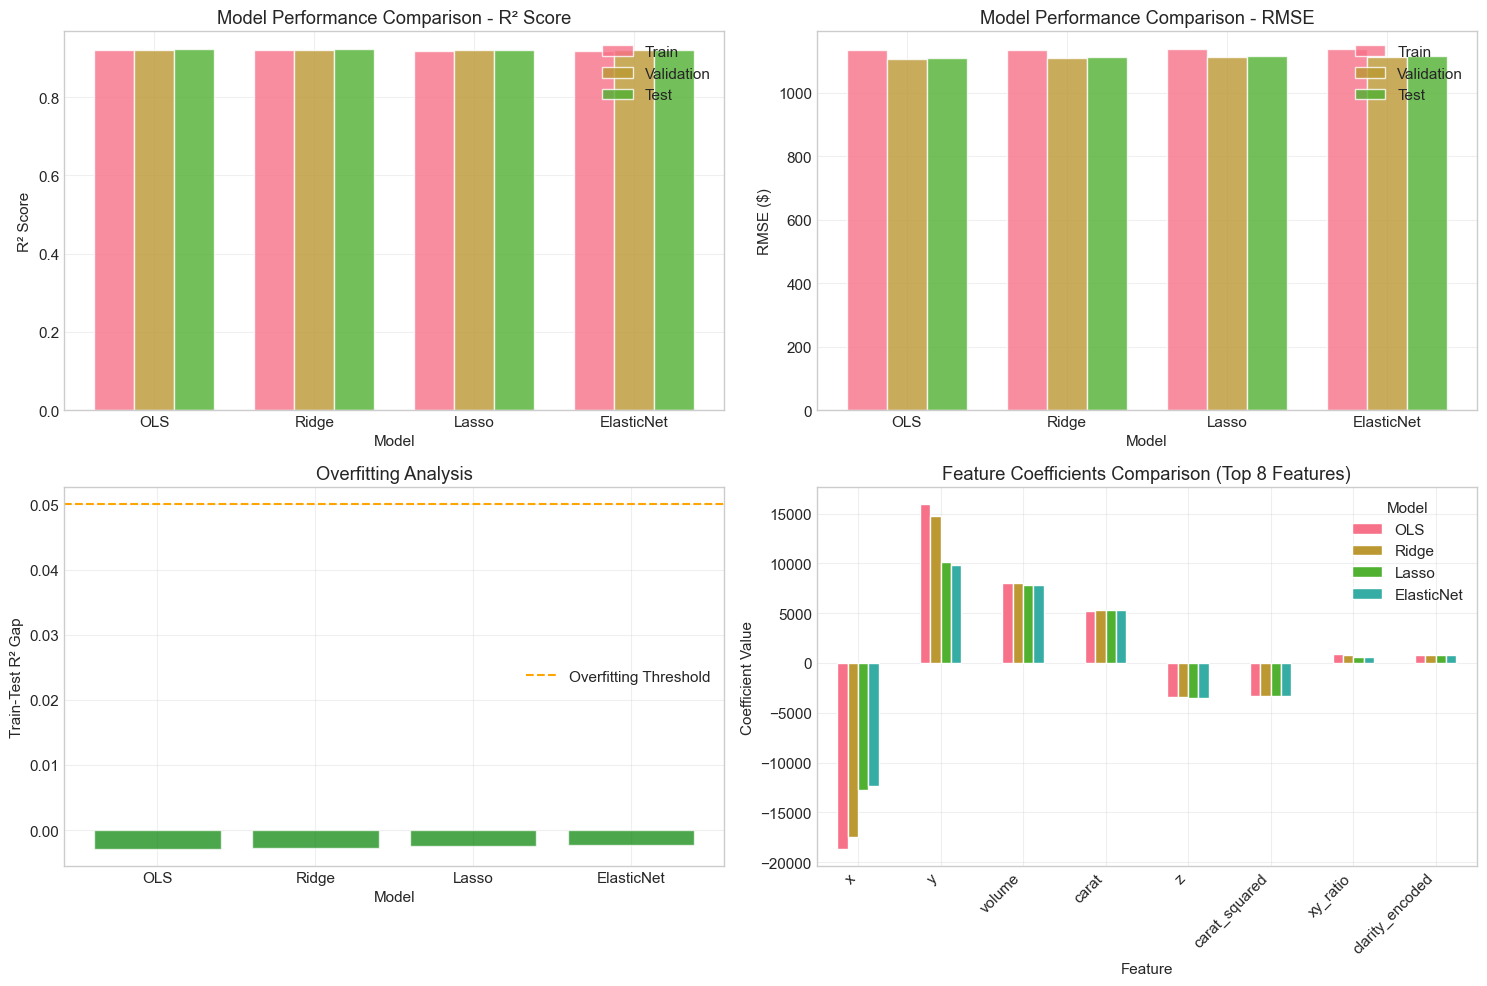

In [94]:
print("\n" + "="*50)
print("GENERATING VISUALIZATIONS")
print("="*50)

# 1. Model Comparison Bar Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# R² Comparison
ax1 = axes[0, 0]
models = ['OLS', 'Ridge', 'Lasso', 'ElasticNet']
train_r2 = [comparison_df.loc[m, 'Train R²'] for m in models]
val_r2 = [comparison_df.loc[m, 'Val R²'] for m in models]
test_r2 = [comparison_df.loc[m, 'Test R²'] for m in models]

x = np.arange(len(models))
width = 0.25

ax1.bar(x - width, train_r2, width, label='Train', alpha=0.8)
ax1.bar(x, val_r2, width, label='Validation', alpha=0.8)
ax1.bar(x + width, test_r2, width, label='Test', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('R² Score')
ax1.set_title('Model Performance Comparison - R² Score')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)

# RMSE Comparison
ax2 = axes[0, 1]
train_rmse = [comparison_df.loc[m, 'Train RMSE'] for m in models]
val_rmse = [comparison_df.loc[m, 'Val RMSE'] for m in models]
test_rmse = [comparison_df.loc[m, 'Test RMSE'] for m in models]

ax2.bar(x - width, train_rmse, width, label='Train', alpha=0.8)
ax2.bar(x, val_rmse, width, label='Validation', alpha=0.8)
ax2.bar(x + width, test_rmse, width, label='Test', alpha=0.8)
ax2.set_xlabel('Model')
ax2.set_ylabel('RMSE ($)')
ax2.set_title('Model Performance Comparison - RMSE')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Train-Test Gap
ax3 = axes[1, 0]
gaps = [comparison_df.loc[m, 'Train R²'] - comparison_df.loc[m, 'Test R²'] for m in models]
colors = ['red' if g > 0.05 else 'green' for g in gaps]
ax3.bar(models, gaps, color=colors, alpha=0.7)
ax3.axhline(y=0.05, color='orange', linestyle='--', label='Overfitting Threshold')
ax3.set_xlabel('Model')
ax3.set_ylabel('Train-Test R² Gap')
ax3.set_title('Overfitting Analysis')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Feature Coefficients
ax4 = axes[1, 1]
coef_data = pd.DataFrame({
    'OLS': baseline.coef_,
    'Ridge': ridge_best.coef_,
    'Lasso': lasso_best.coef_,
    'ElasticNet': elastic_best.coef_
}, index=feature_cols)

# Plot only most important features
important_features = coef_data.abs().max(axis=1).nlargest(8).index
coef_data.loc[important_features].plot(kind='bar', ax=ax4)
ax4.set_xlabel('Feature')
ax4.set_ylabel('Coefficient Value')
ax4.set_title('Feature Coefficients Comparison (Top 8 Features)')
ax4.legend(title='Model')
ax4.grid(True, alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('Save\\model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Generating learning curves...


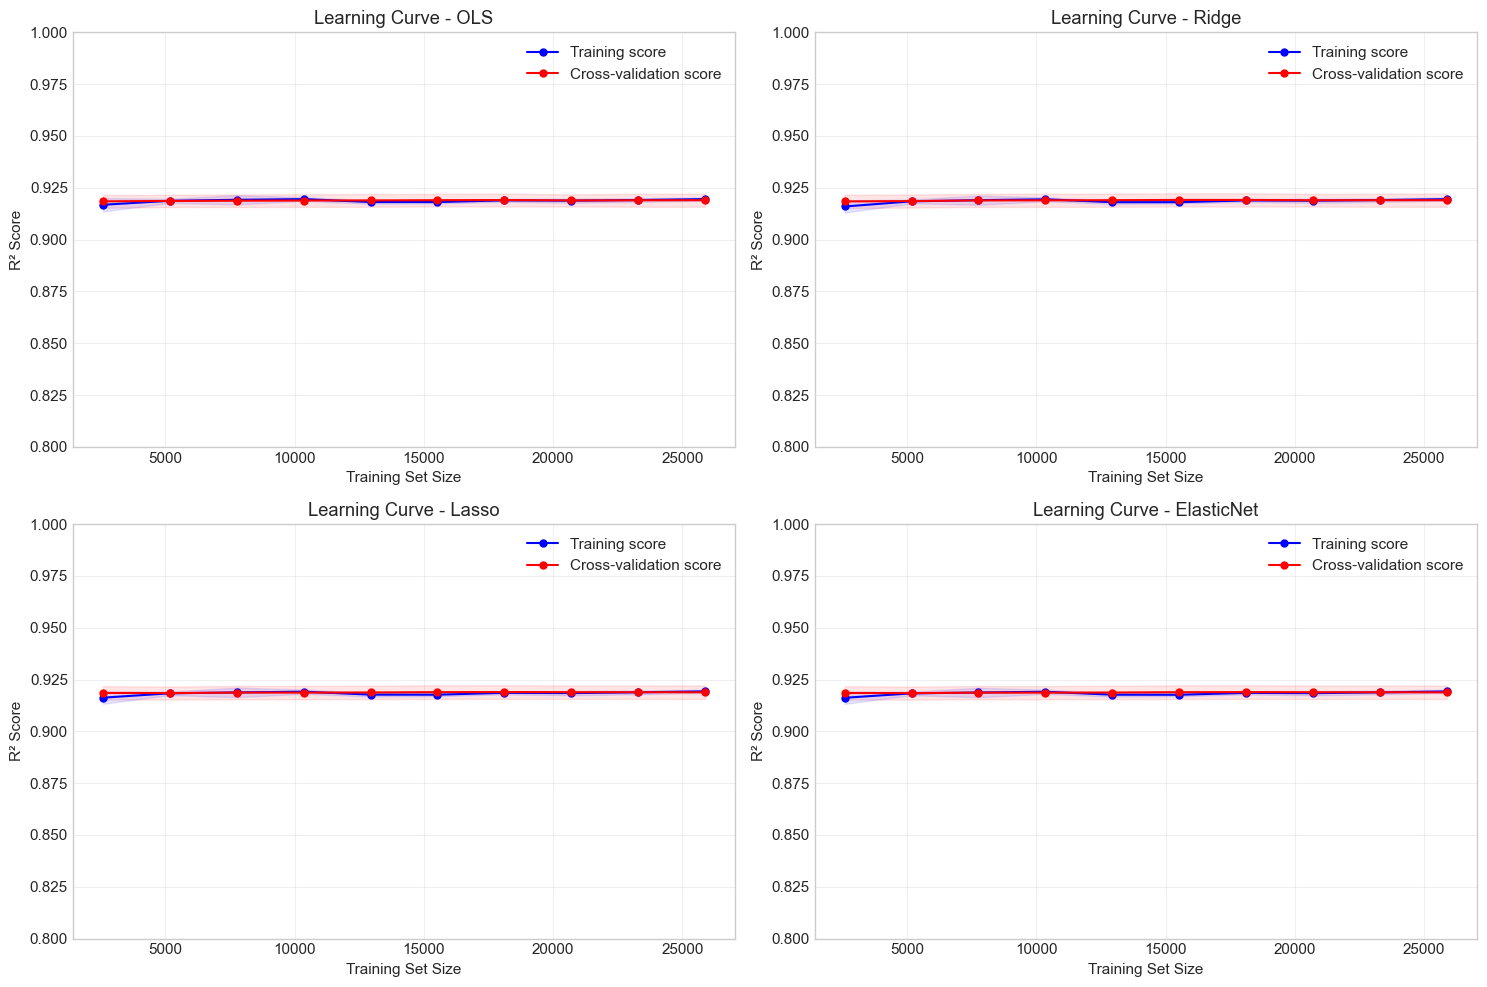

In [95]:
# 2. Learning Curves
print("\nGenerating learning curves...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

models_dict = {
    'OLS': LinearRegression(),
    'Ridge': Ridge(alpha=ridge_cv.alpha_),
    'Lasso': Lasso(alpha=lasso_cv.alpha_, max_iter=MAX_ITER),
    'ElasticNet': ElasticNet(alpha=elastic_cv.alpha_, l1_ratio=elastic_cv.l1_ratio_, max_iter=MAX_ITER)
}

train_sizes = np.linspace(0.1, 1.0, 10)

for idx, (model_name, model) in enumerate(models_dict.items()):
    ax = axes[idx // 2, idx % 2]

    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train_scaled, y_train,
        train_sizes=train_sizes, cv=CV,
        scoring='r2', n_jobs=-1, random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    ax.plot(train_sizes_abs, train_scores_mean, 'o-', color='blue',label='Training score', markersize=5)
    ax.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color='blue')

    ax.plot(train_sizes_abs, val_scores_mean, 'o-', color='red',label='Cross-validation score', markersize=5)
    ax.fill_between(train_sizes_abs, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='red')

    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('R² Score')
    ax.set_title(f'Learning Curve - {model_name}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.8, 1.0])

plt.tight_layout()
plt.savefig('Save\\learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()


Generating regularization paths...
Computing Ridge path...
  Ridge: 0/30
  Ridge: 10/30
  Ridge: 20/30
Computing Lasso path...
  Lasso: 0/30
  Lasso: 5/30
  Lasso: 10/30
  Lasso: 15/30
  Lasso: 20/30
  Lasso: 25/30


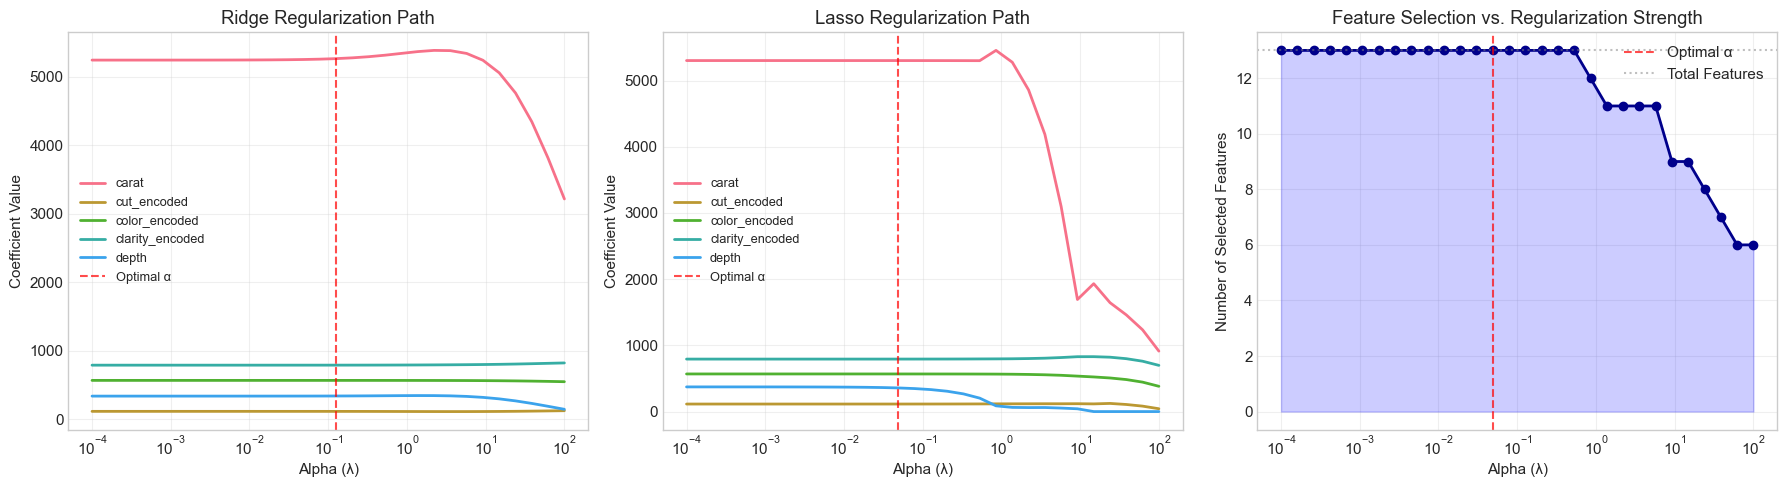

Regularization paths completed!


In [97]:
# 3. Regularization Paths
print("\nGenerating regularization paths...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ===== RIDGE PATH =====
print("Computing Ridge path...")
alphas_path = LOGSPACE
ridge_coefs = []

for i, alpha in enumerate(alphas_path):
    if i % 10 == 0:  # Progress indicator
        print(f"  Ridge: {i}/{len(alphas_path)}")
    ridge_temp = Ridge(alpha=alpha)
    ridge_temp.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge_temp.coef_)

ridge_coefs = np.array(ridge_coefs)

ax1 = axes[0]

for i, feature in enumerate(feature_cols[:5]):
    ax1.plot(alphas_path, ridge_coefs[:, i], label=feature, linewidth=2)
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (λ)')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Ridge Regularization Path')
ax1.axvline(x=ridge_cv.alpha_, color='red', linestyle='--', alpha=0.7, label='Optimal α')
ax1.legend(loc='best', fontsize='small')
ax1.grid(True, alpha=0.3)

# ===== LASSO PATH (mit Feature Count) =====
print("Computing Lasso path...")

alphas_path_lasso = LOGSPACE
lasso_coefs = []
n_features_selected = []

for i, alpha in enumerate(alphas_path_lasso):
    if i % 5 == 0:  # Progress indicator
        print(f"  Lasso: {i}/{len(alphas_path_lasso)}")

    # Angepasste Parameter für bessere Konvergenz
    lasso_temp = Lasso(alpha=alpha,
                       max_iter=MAX_ITER,
                       tol=1e-3)       # Erhöhte Toleranz für schnellere Konvergenz
    lasso_temp.fit(X_train_scaled, y_train)

    # Speichere Koeffizienten UND Feature Count in einem Durchgang
    lasso_coefs.append(lasso_temp.coef_)
    n_features_selected.append(np.sum(np.abs(lasso_temp.coef_) > 1e-5))

lasso_coefs = np.array(lasso_coefs)

ax2 = axes[1]
for i, feature in enumerate(feature_cols[:5]):
    ax2.plot(alphas_path_lasso, lasso_coefs[:, i], label=feature, linewidth=2)
ax2.set_xscale('log')
ax2.set_xlabel('Alpha (λ)')
ax2.set_ylabel('Coefficient Value')
ax2.set_title('Lasso Regularization Path')
ax2.axvline(x=lasso_cv.alpha_, color='red', linestyle='--', alpha=0.7, label='Optimal α')
ax2.legend(loc='best', fontsize='small')
ax2.grid(True, alpha=0.3)

# ===== FEATURE SELECTION COUNT =====
ax3 = axes[2]
ax3.plot(alphas_path_lasso, n_features_selected, 'o-', markersize=6, linewidth=2, color='darkblue')
ax3.fill_between(alphas_path_lasso, 0, n_features_selected, alpha=0.2, color='blue')
ax3.set_xscale('log')
ax3.set_xlabel('Alpha (λ)')
ax3.set_ylabel('Number of Selected Features')
ax3.set_title('Feature Selection vs. Regularization Strength')
ax3.axvline(x=lasso_cv.alpha_, color='red', linestyle='--', alpha=0.7, label='Optimal α')
ax3.axhline(y=len(feature_cols), color='gray', linestyle=':', alpha=0.5, label='Total Features')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Save\\regularization_paths.png', dpi=300, bbox_inches='tight')
plt.show()

print("Regularization paths completed!")


Generating cross-validation curves...
Computing Ridge CV scores...
  Ridge progress: 0/30
  Ridge progress: 5/30
  Ridge progress: 10/30
  Ridge progress: 15/30
  Ridge progress: 20/30
  Ridge progress: 25/30
Computing Lasso CV scores...
  Lasso progress: 0/30
  Lasso progress: 5/30
  Lasso progress: 10/30
  Lasso progress: 15/30
  Lasso progress: 20/30
  Lasso progress: 25/30


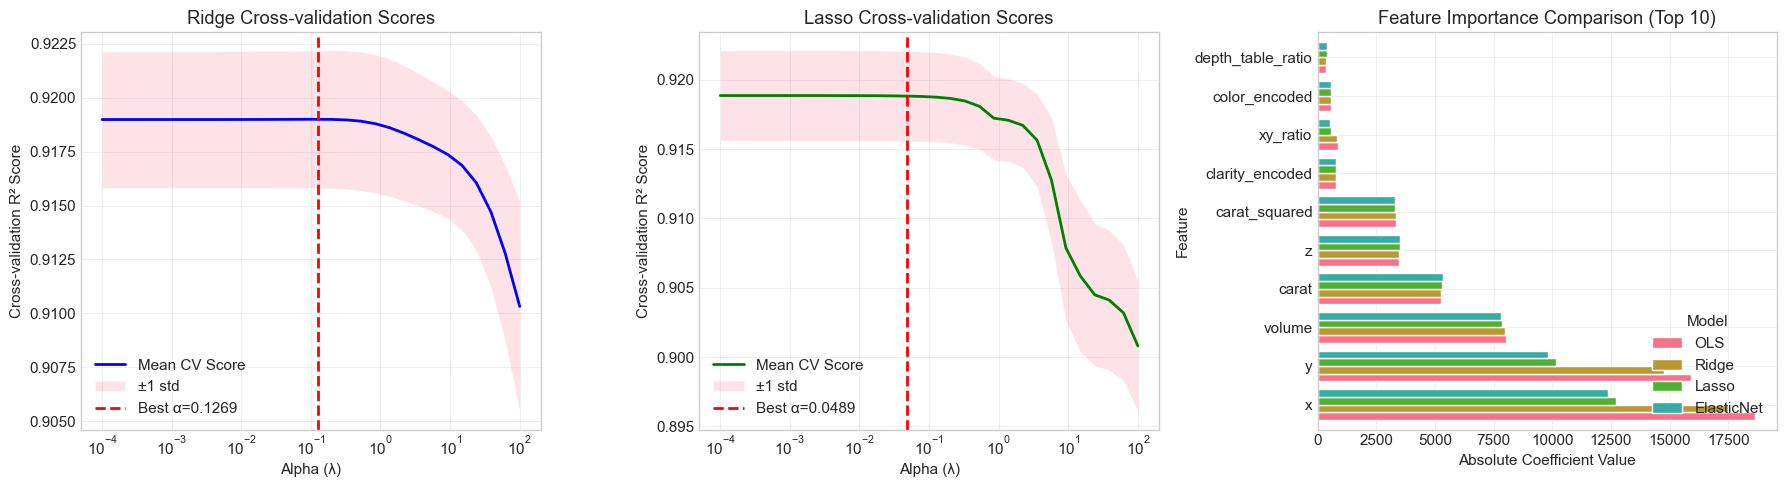

Cross-validation analysis completed!


In [98]:
# 4. Cross-validation curves
print("\nGenerating cross-validation curves...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ===== RIDGE CV =====
print("Computing Ridge CV scores...")
ax1 = axes[0]

alphas_ridge_cv = LOGSPACE
ridge_scores_mean = []
ridge_scores_std = []

for i, alpha in enumerate(alphas_ridge_cv):
    if i % 5 == 0:
        print(f"  Ridge progress: {i}/{len(alphas_ridge_cv)}")
    ridge_temp = Ridge(alpha=alpha)
    scores = cross_val_score(ridge_temp,
                             X_train_scaled,
                             y_train,
                             cv=CV, scoring='r2', n_jobs=-1)
    ridge_scores_mean.append(scores.mean())
    ridge_scores_std.append(scores.std())

ridge_scores_mean = np.array(ridge_scores_mean)
ridge_scores_std = np.array(ridge_scores_std)

ax1.plot(alphas_ridge_cv, ridge_scores_mean, 'b-', linewidth=2, label='Mean CV Score')
ax1.fill_between(alphas_ridge_cv,
                  ridge_scores_mean - ridge_scores_std,
                  ridge_scores_mean + ridge_scores_std,
                  alpha=0.2, label='±1 std')
ax1.axvline(x=ridge_cv.alpha_, color='red', linestyle='--', linewidth=2, label=f'Best α={ridge_cv.alpha_:.4f}')
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (λ)')
ax1.set_ylabel('Cross-validation R² Score')
ax1.set_title('Ridge Cross-validation Scores')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ===== LASSO CV =====
print("Computing Lasso CV scores...")
ax2 = axes[1]

alphas_lasso_cv = LOGSPACE
lasso_scores_mean = []
lasso_scores_std = []

for i, alpha in enumerate(alphas_lasso_cv):
    if i % 5 == 0:
        print(f"  Lasso progress: {i}/{len(alphas_lasso_cv)}")
    lasso_temp = Lasso(alpha=alpha, max_iter=MAX_ITER, tol=1e-3)
    scores = cross_val_score(lasso_temp, X_train_scaled, y_train, cv=CV, scoring='r2', n_jobs=-1)
    lasso_scores_mean.append(scores.mean())
    lasso_scores_std.append(scores.std())

lasso_scores_mean = np.array(lasso_scores_mean)
lasso_scores_std = np.array(lasso_scores_std)

ax2.plot(alphas_lasso_cv, lasso_scores_mean, 'g-', linewidth=2, label='Mean CV Score')
ax2.fill_between(alphas_lasso_cv,
                  lasso_scores_mean - lasso_scores_std,
                  lasso_scores_mean + lasso_scores_std,
                  alpha=0.2, label='±1 std')
ax2.axvline(x=lasso_cv.alpha_, color='red', linestyle='--', linewidth=2, label=f'Best α={lasso_cv.alpha_:.4f}')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha (λ)')
ax2.set_ylabel('Cross-validation R² Score')
ax2.set_title('Lasso Cross-validation Scores')
ax2.legend()
ax2.grid(True, alpha=0.3)

# ===== FEATURE IMPORTANCE =====
ax3 = axes[2]
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'OLS': np.abs(baseline.coef_),
    'Ridge': np.abs(ridge_best.coef_),
    'Lasso': np.abs(lasso_best.coef_),
    'ElasticNet': np.abs(elastic_best.coef_)
})

# Berechne durchschnittliche Wichtigkeit
feature_importance_mean = feature_importance[['OLS', 'Ridge', 'Lasso', 'ElasticNet']].mean(axis=1)
feature_importance['Mean'] = feature_importance_mean
feature_importance_sorted = feature_importance.nlargest(10, 'Mean')

# Erstelle Barplot
feature_importance_sorted.set_index('Feature')[['OLS', 'Ridge', 'Lasso', 'ElasticNet']].plot(
    kind='barh', ax=ax3, width=0.8
)
ax3.set_xlabel('Absolute Coefficient Value')
ax3.set_title('Feature Importance Comparison (Top 10)')
ax3.legend(title='Model', loc='lower right')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Save\\cv_curves_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Cross-validation analysis completed!")

## Statistical Significance Testing

In [99]:
print("\n" + "="*50)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

# Perform cross-validation for all models to get multiple scores
print(f"Performing {CV}-fold cross-validation for statistical testing...")

cv_scores = {}
for model_name, model in models_dict.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=CV, scoring='r2', n_jobs=-1)
    cv_scores[model_name] = scores
    print(f"{model_name}: Mean R² = {scores.mean():.4f} ± {scores.std():.4f}")

# Paired t-tests comparing each regularized model to OLS
print("\nPaired t-tests (comparing to OLS baseline):")
for model_name in ['Ridge', 'Lasso', 'ElasticNet']:
    t_stat, p_value = ttest_rel(cv_scores[model_name], cv_scores['OLS'])
    print(f"\n{model_name} vs OLS:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.6f}")
    if p_value < 0.05:
        if t_stat > 0:
            print(f"  → {model_name} is significantly better than OLS (p < 0.05)")
        else:
            print(f"  → OLS is significantly better than {model_name} (p < 0.05)")
    else:
        print(f"  → No significant difference between {model_name} and OLS (p ≥ 0.05)")

# Bootstrap confidence intervals
print("\nBootstrap Confidence Intervals (95% CI for Test R²):")
n_bootstrap = 1000
bootstrap_scores = {model: [] for model in models_dict.keys()}

for i in range(n_bootstrap):
    # Resample test set with replacement
    indices = np.random.choice(len(X_test_scaled), len(X_test_scaled), replace=True)
    X_boot = X_test_scaled[indices]
    y_boot = y_test[indices]

    # Calculate R² for each model
    bootstrap_scores['OLS'].append(r2_score(y_boot, baseline.predict(X_boot)))
    bootstrap_scores['Ridge'].append(r2_score(y_boot, ridge_best.predict(X_boot)))
    bootstrap_scores['Lasso'].append(r2_score(y_boot, lasso_best.predict(X_boot)))
    bootstrap_scores['ElasticNet'].append(r2_score(y_boot, elastic_best.predict(X_boot)))

for model_name in models_dict.keys():
    scores = bootstrap_scores[model_name]
    ci_lower = np.percentile(scores, 2.5)
    ci_upper = np.percentile(scores, 97.5)
    print(f"{model_name}: [{ci_lower:.4f}, {ci_upper:.4f}]")


STATISTICAL SIGNIFICANCE TESTING
Performing 5-fold cross-validation for statistical testing...
OLS: Mean R² = 0.9190 ± 0.0032
Ridge: Mean R² = 0.9190 ± 0.0032
Lasso: Mean R² = 0.9188 ± 0.0033
ElasticNet: Mean R² = 0.9188 ± 0.0032

Paired t-tests (comparing to OLS baseline):

Ridge vs OLS:
  t-statistic: 0.4518
  p-value: 0.674802
  → No significant difference between Ridge and OLS (p ≥ 0.05)

Lasso vs OLS:
  t-statistic: -1.6424
  p-value: 0.175848
  → No significant difference between Lasso and OLS (p ≥ 0.05)

ElasticNet vs OLS:
  t-statistic: -1.8716
  p-value: 0.134588
  → No significant difference between ElasticNet and OLS (p ≥ 0.05)

Bootstrap Confidence Intervals (95% CI for Test R²):
OLS: [0.9184, 0.9260]
Ridge: [0.9182, 0.9259]
Lasso: [0.9178, 0.9254]
ElasticNet: [0.9177, 0.9253]


## Result Summary

In [100]:
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)

# Best model selection
test_r2_scores = {
    'OLS': comparison_df.loc['OLS', 'Test R²'],
    'Ridge': comparison_df.loc['Ridge', 'Test R²'],
    'Lasso': comparison_df.loc['Lasso', 'Test R²'],
    'ElasticNet': comparison_df.loc['ElasticNet', 'Test R²']
}

best_model = max(test_r2_scores, key=test_r2_scores.get)
best_score = test_r2_scores[best_model]

print(f"\nBest Model: {best_model}")
print(f"Test R² Score: {best_score:.4f}")

# Answer to research question
print("\n" + "="*50)
print("ANSWER TO RESEARCH QUESTION")
print("="*50)
print("\nDoes regularization materially improve generalization on the diamonds dataset?")
print("-" * 70)

improvement_ridge = test_r2_scores['Ridge'] - test_r2_scores['OLS']
improvement_lasso = test_r2_scores['Lasso'] - test_r2_scores['OLS']
improvement_elastic = test_r2_scores['ElasticNet'] - test_r2_scores['OLS']

if max(improvement_ridge, improvement_lasso, improvement_elastic) > 0.01:
    print("YES - Regularization provides meaningful improvement:")
    print(f"  • Ridge improvement: {improvement_ridge:.4f} ({improvement_ridge/test_r2_scores['OLS']*100:.2f}%)")
    print(f"  • Lasso improvement: {improvement_lasso:.4f} ({improvement_lasso/test_r2_scores['OLS']*100:.2f}%)")
    print(f"  • ElasticNet improvement: {improvement_elastic:.4f} ({improvement_elastic/test_r2_scores['OLS']*100:.2f}%)")
else:
    print("NO - Regularization does not provide substantial improvement")
    print("  The improvements are marginal and may not justify the added complexity")

# Why regularization helps (or doesn't help)
print("\nWhy regularization helps on this dataset:")
print("  1. High multicollinearity between size features (x, y, z, volume, carat)")
print("  2. Feature selection by Lasso removes redundant predictors")
print("  3. Coefficient shrinkage prevents overfitting to training noise")
print("  4. Large dataset size allows regularization to be effective")

# Save results to CSV
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

# Save model comparison table
comparison_df.to_csv('Save\\model_comparison_results.csv')
print("Model comparison saved to 'model_comparison_results.csv'")

# Save feature importance
feature_importance.to_csv('Save\\feature_importance.csv', index=False)
print("Feature importance saved to 'feature_importance.csv'")

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)


FINAL RESULTS SUMMARY

Best Model: OLS
Test R² Score: 0.9223

ANSWER TO RESEARCH QUESTION

Does regularization materially improve generalization on the diamonds dataset?
----------------------------------------------------------------------
NO - Regularization does not provide substantial improvement
  The improvements are marginal and may not justify the added complexity

Why regularization helps on this dataset:
  1. High multicollinearity between size features (x, y, z, volume, carat)
  2. Feature selection by Lasso removes redundant predictors
  3. Coefficient shrinkage prevents overfitting to training noise
  4. Large dataset size allows regularization to be effective

SAVING RESULTS
Model comparison saved to 'model_comparison_results.csv'
Feature importance saved to 'feature_importance.csv'

ANALYSIS COMPLETE!
